<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%8F%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC_410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰 센서 데이터로 분류

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
!curl -L https://bit.ly/36LsyVs -o smartphone_human.txt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   153  100   153    0     0    250      0 --:--:-- --:--:-- --:--:--   250
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  1034    0  1034    0     0    572      0 --:--:--  0:00:01 --:--:--  2167
100 10.5M  100 10.5M    0     0  3121k      0  0:00:03  0:00:03 --:--:-- 4649k


In [0]:
!unzip smartphone_human.txt.zip

Archive:  smartphone_human.txt.zip
  inflating: smartphone_human.txt    
   creating: __MACOSX/
  inflating: __MACOSX/._smartphone_human.txt  


In [0]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [0]:
!head -5 smartphone_human.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [0]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone_human.txt', header=None, names=column_names)
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)
df.dropna(axis=0, how='any', inplace=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user-id      1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [0]:
df.shape

(1098203, 6)

In [0]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

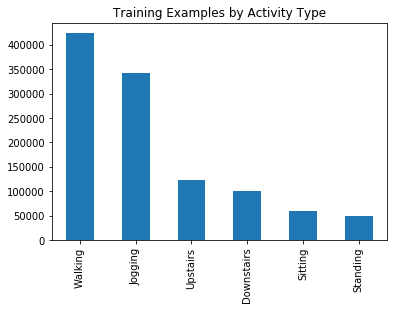

In [0]:
# plt.figure(dpi=200)
df['activity'].value_counts().plot(kind='bar',
    title='Training Examples by Activity Type')
plt.show()

In [0]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

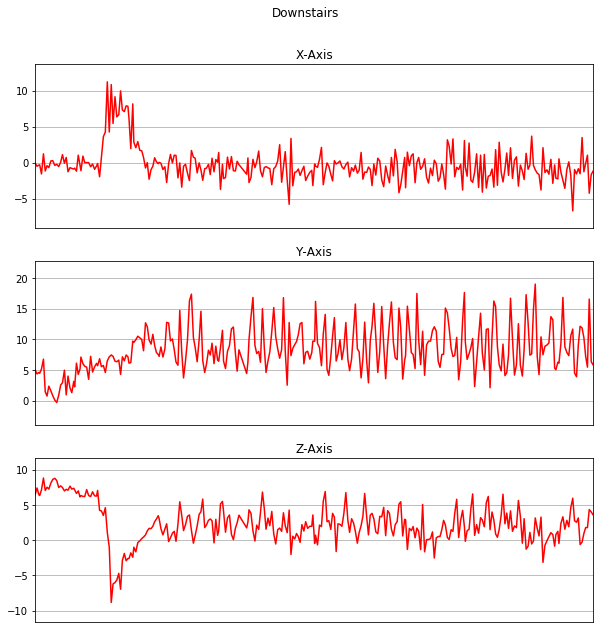

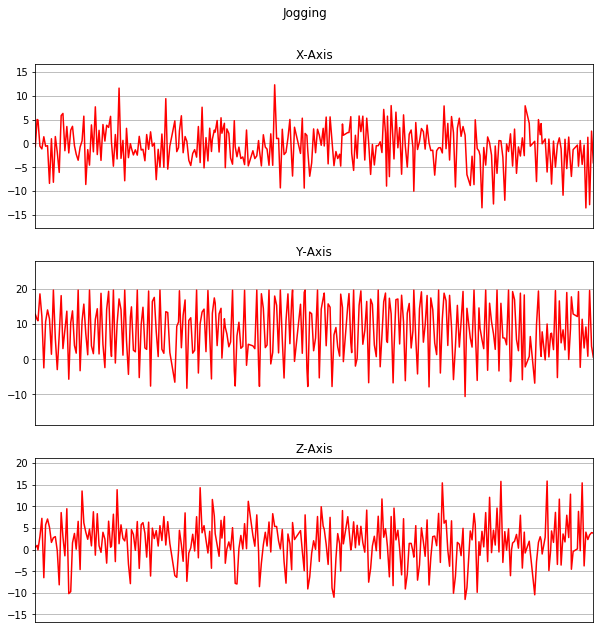

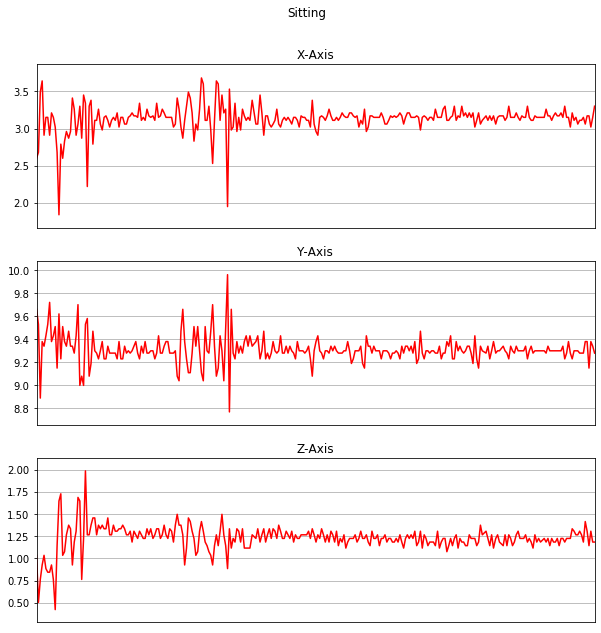

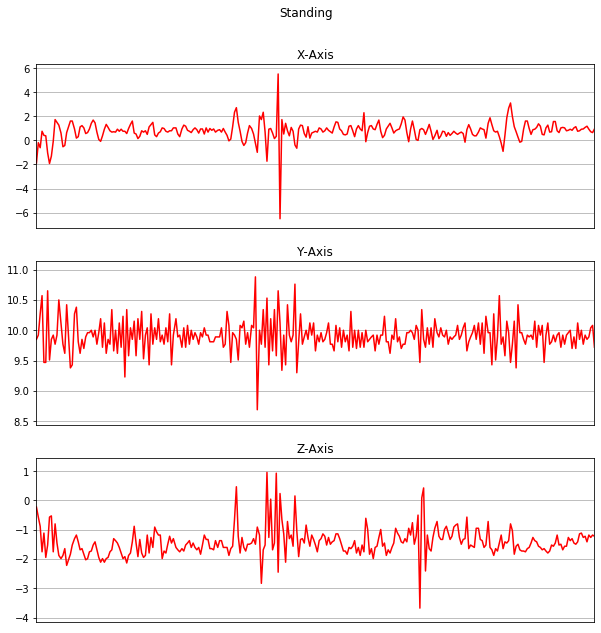

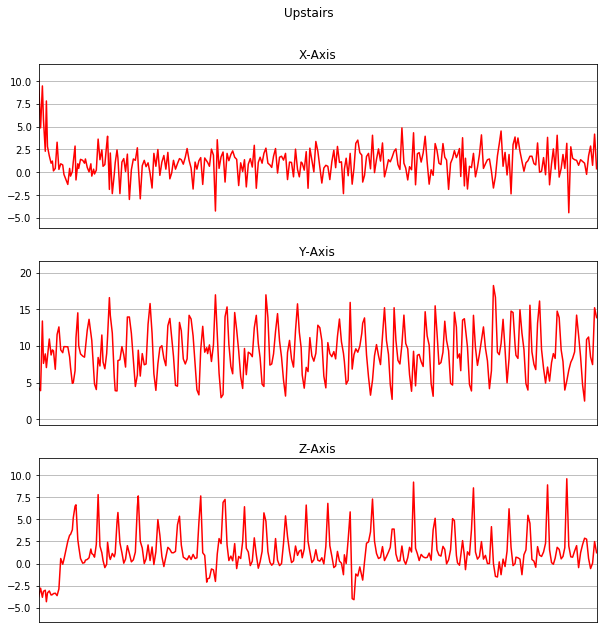

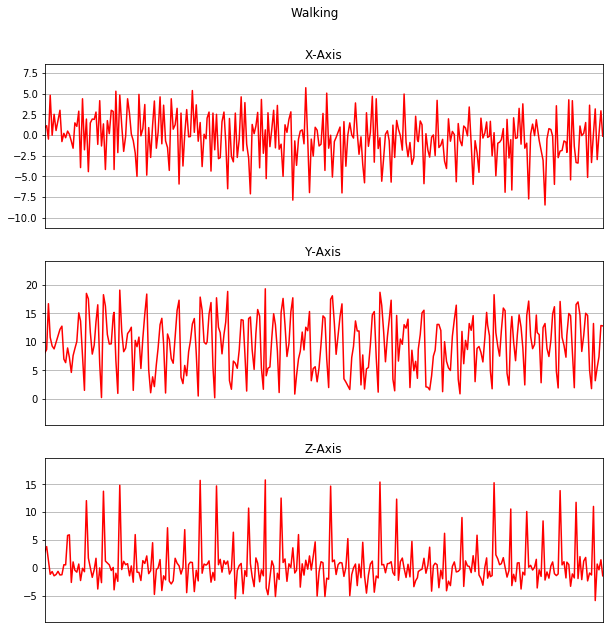

In [0]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

In [0]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [0]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [0]:
df['activity'].value_counts()

Walking       423905
Jogging       330330
Upstairs      122598
Downstairs    100194
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [0]:
test = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4]
stats.mode(test)

ModeResult(mode=array([3]), count=array([15]))

In [0]:
z = stats.mode(df['act'][0:100])
z[0][0], z[1][0]

(1, 100)

In [0]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'act'],
      dtype='object')

In [0]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [0]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


In [0]:
# N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다 
N = 100
X, y = [], []
for i in range(0, len(df)-N+1, N):
    z = stats.mode(df['act'][i: i+N])
    action, count = z[0][0], z[1][0]
    if count == N:
        xs = df['x-axis'].values[i: i + N]
        ys = df['y-axis'].values[i: i + N]
        zs = df['z-axis'].values[i: i + N]
        X.append([xs, ys, zs])
        y.append(action)
X = np.transpose(X, (0,2,1))
y = np.array(y)

In [0]:
X2 = X[:,:,:]

In [0]:
X.shape

(10469, 100, 3)

In [0]:
y = np_utils.to_categorical(y)
y[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
X

## 랜덤 포레스트

In [0]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
%matplotlib inline

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.7639419404125286

# MLP

In [0]:
y.shape

(10469, 6)

In [0]:
model_m = Sequential()
# model_m.add(Reshape((N, 1), input_shape=(N,)))
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(100, activation='relu',input_shape=(N*3,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
# model_m.summary()

In [0]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=10,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6280 samples, validate on 1571 samples
Epoch 1/30





6280/6280 [==============================] - 9s 1ms/step - loss: 0.7812 - acc: 0.7279 - val_loss: 0.5045 - val_acc: 0.8211
Epoch 2/30
6280/6280 [==============================] - 4s 579us/step - loss: 0.4070 - acc: 0.8521 - val_loss: 0.5261 - val_acc: 0.8218
Epoch 3/30
6280/6280 [==============================] - 4s 609us/step - loss: 0.2733 - acc: 0.9057 - val_loss: 0.4525 - val_acc: 0.8409
Epoch 4/30
6280/6280 [==============================] - 4s 599us/step - loss: 0.1887 - acc: 0.9361 - val_loss: 0.4525 - val_acc: 0.8606
Epoch 5/30
6280/6280 [==============================] - 4s 588us/step - loss: 0.1318 - acc: 0.9510 - val_loss: 0.4532 - val_acc: 0.8466
Epoch 6/30
6280/6280 [==============================] - 4s 611us/step - loss: 0.0886 - acc: 0.9720 - val_loss: 0.5251 - val_acc: 0.8600
Epoch 7/30
6280/6280 [============

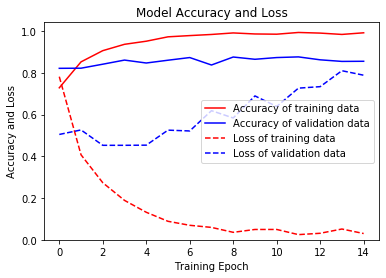

In [0]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    
show_4_graphs(history)

In [0]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

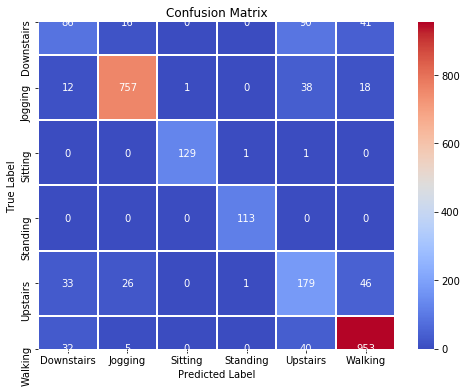

              precision    recall  f1-score   support

           0       0.53      0.37      0.43       233
           1       0.94      0.92      0.93       826
           2       0.99      0.98      0.99       131
           3       0.98      1.00      0.99       113
           4       0.51      0.63      0.57       285
           5       0.90      0.93      0.91      1030

    accuracy                           0.85      2618
   macro avg       0.81      0.80      0.80      2618
weighted avg       0.85      0.85      0.84      2618



In [0]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# CNN (Conv1D)

In [0]:
model_m = Sequential()
model_m.add(Conv1D(64, 10, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(64, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(128, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
# print(model_m.summary())



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6280 samples, validate on 1571 samples
Epoch 1/30
6280/6280 [==============================] - 6s 972us/step - loss: 0.6195 - acc: 0.7726 - val_loss: 0.3388 - val_acc: 0.8638
Epoch 2/30
6280/6280 [==============================] - 3s 462us/step - loss: 0.3156 - acc: 0.8900 - val_loss: 0.2068 - val_acc: 0.9255
Epoch 3/30
6280/6280 [==============================] - 3s 436us/step - loss: 0.2040 - acc: 0.9306 - val_loss: 0.1387 - val_acc: 0.9586
Epoch 4/30
6280/6280 [==============================] - 3s 449us/step - loss: 0.1541 - acc: 0.9525 - val_loss: 0.1072 - val_acc: 0.9656
Epoch 5/30
6280/6280 [==============================] - 3s 444us/step - loss: 0.1137 - acc: 0.9634 - val_loss: 0.0978 - val_acc: 0.9644
Epoch 6/30
6280/6280 [==============================] - 3s 432us/step - loss: 0.0860 - acc: 0.9736 - val_loss: 0.0881 - val_acc: 0.9720
Epoch 7/30
6280/6280 [==============================] - 3s 455us/step - loss: 0.0783 - acc: 0.9745 - val_loss: 0.0598 - val_acc: 0.9796


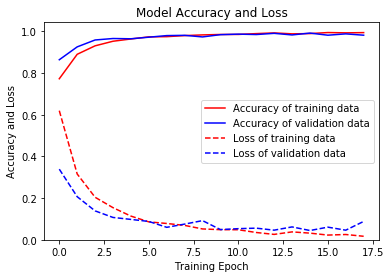

In [0]:
show_4_graphs(history)

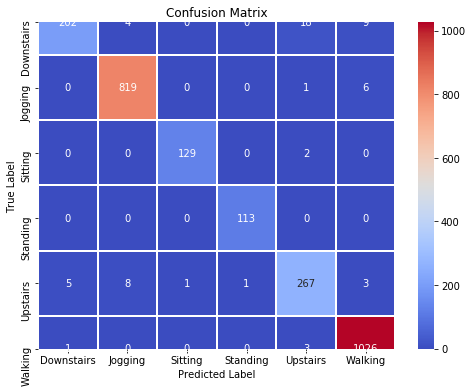

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       233
           1       0.99      0.99      0.99       826
           2       0.99      0.98      0.99       131
           3       0.99      1.00      1.00       113
           4       0.92      0.94      0.93       285
           5       0.98      1.00      0.99      1030

    accuracy                           0.98      2618
   macro avg       0.97      0.96      0.97      2618
weighted avg       0.98      0.98      0.98      2618



In [0]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# RNN

In [0]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# model.summary()

In [0]:
history = model.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6280 samples, validate on 1571 samples
Epoch 1/30
6280/6280 [==============================] - 122s 19ms/step - loss: 0.7831 - acc: 0.7272 - val_loss: 0.4611 - val_acc: 0.8294
Epoch 2/30
6280/6280 [==============================] - 121s 19ms/step - loss: 0.4058 - acc: 0.8537 - val_loss: 0.2733 - val_acc: 0.9077
Epoch 3/30
6280/6280 [==============================] - 121s 19ms/step - loss: 0.2176 - acc: 0.9272 - val_loss: 0.1322 - val_acc: 0.9586
Epoch 4/30
6280/6280 [==============================] - 123s 20ms/step - loss: 0.1499 - acc: 0.9540 - val_loss: 0.1134 - val_acc: 0.9599
Epoch 5/30
4820/6280 [======================>.......] - ETA: 25s - loss: 0.1015 - acc: 0.9705

In [0]:
show_4_graphs(history)

In [0]:
y_pred = model.predict(X_test)
show_results(y_test, y_pred)